In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv


In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV, validation_curve, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
gdz = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv', parse_dates=['Tarih'])
sub_samp = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', parse_dates=['Tarih'])
med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv', parse_dates=['Tarih'])

In [4]:
sub_samp.head(2)

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,0.000
1,2022-08-01 01:00:00,0.000


In [5]:
sub_samp['Tarih'].min(), sub_samp['Tarih'].max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-31 23:00:00'))

In [6]:
sub_samp['Dağıtılan Enerji (MWh)'] = np.nan

In [7]:
df = pd.concat([gdz, sub_samp], ignore_index=True)

In [8]:
def create_date_features(df):
    df['hour'] = df.Tarih.dt.hour
    df['month'] = df.Tarih.dt.month
    df['quarter'] = df.Tarih.dt.quarter
    df['day_of_month'] = df.Tarih.dt.day
    df['day_of_year'] = df.Tarih.dt.dayofyear
    df['week_of_year'] = df.Tarih.dt.weekofyear
    df['day_of_week'] = df.Tarih.dt.dayofweek
    df['year'] = df.Tarih.dt.year
    df['is_wknd'] = df.Tarih.dt.weekday // 4
    df['is_month_start'] = df.Tarih.dt.is_month_start.astype(int)
    df['is_month_end'] = df.Tarih.dt.is_month_end.astype(int)
    return df


df = create_date_features(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [9]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

In [10]:
df['is_spring'] = df['Tarih'].apply(is_spring)
df['is_summer'] = df['Tarih'].apply(is_summer)
df['is_autumn'] = df['Tarih'].apply(is_autumn)
df['is_winter'] = df['Tarih'].apply(is_winter)

In [11]:
def extract_ramadan(tarih):
    if str(tarih) >= '2018-05-15' and str(tarih) <= '2018-06-14':
        return 1
    elif str(tarih) >= '2019-05-05' and str(tarih) <= '2019-06-03':
        return 1
    elif str(tarih) >= '2020-04-24' and str(tarih) <= '2020-05-23':
        return 1
    elif str(tarih) >= '2021-04-13' and str(tarih) <= '2021-05-12':
        return 1
    elif str(tarih) >= '2022-04-02' and str(tarih) <= '2022-05-01':
        return 1
    else:
        return 0

In [12]:
df['is_ramadan'] = df['Tarih'].apply(lambda x: extract_ramadan(x))

In [13]:
med['isover'] = True
df = pd.merge(df, 
                 med,
                 how='left',
                 on='Tarih')
df = df[df['isover'].isnull()].drop('isover', axis=1)

In [14]:
df['Dağıtılan Enerji (MWh)'] = np.log(df['Dağıtılan Enerji (MWh)'])

In [15]:
df.groupby(['month']).sum()['Dağıtılan Enerji (MWh)'].sort_values(ascending=False).head(4)

month
7   28533.189
1   28055.709
3   27740.617
5   27285.885
Name: Dağıtılan Enerji (MWh), dtype: float64

Text(0.5, 0, 'Month')

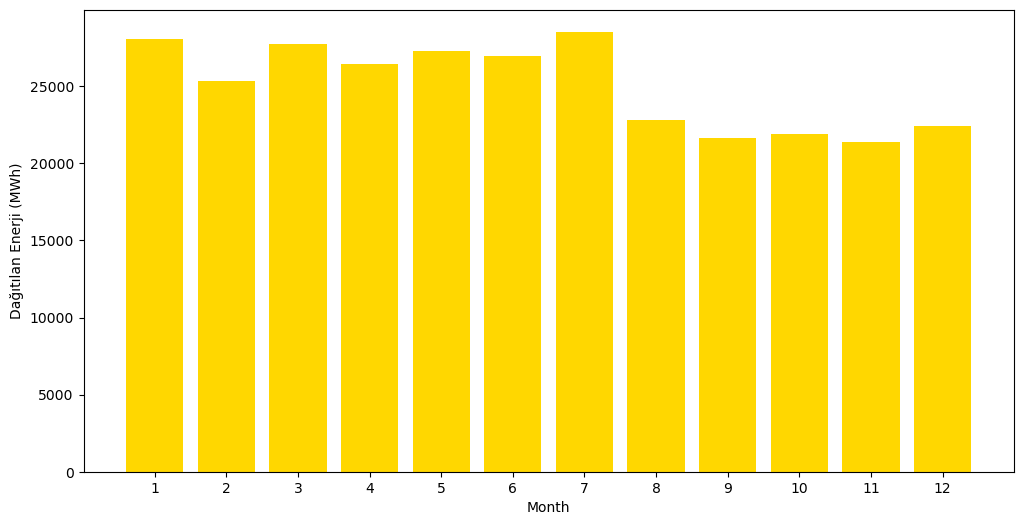

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(range(1,13), df.groupby(['month']).sum()['Dağıtılan Enerji (MWh)'], color='gold')
plt.xticks(range(1,13))
plt.ylabel('Dağıtılan Enerji (MWh)')
plt.xlabel('Month')

Text(0.5, 0, 'Hour')

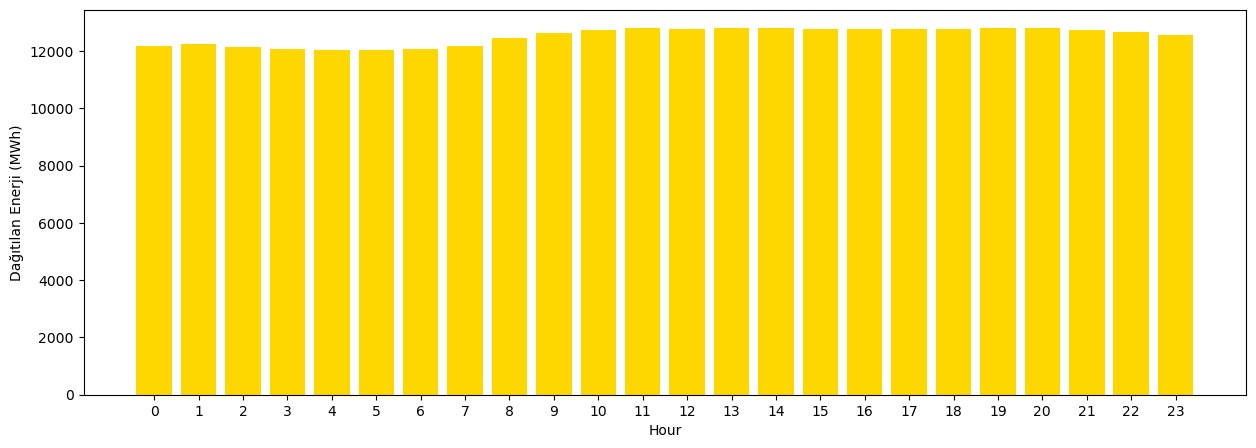

In [17]:
plt.figure(figsize=(15, 5))
plt.bar(range(0,24), df.groupby(['hour']).sum()['Dağıtılan Enerji (MWh)'], color='gold')
plt.xticks(range(0,24))
plt.ylabel('Dağıtılan Enerji (MWh)')
plt.xlabel('Hour')

<AxesSubplot:xlabel='month', ylabel='Dağıtılan Enerji (MWh)'>

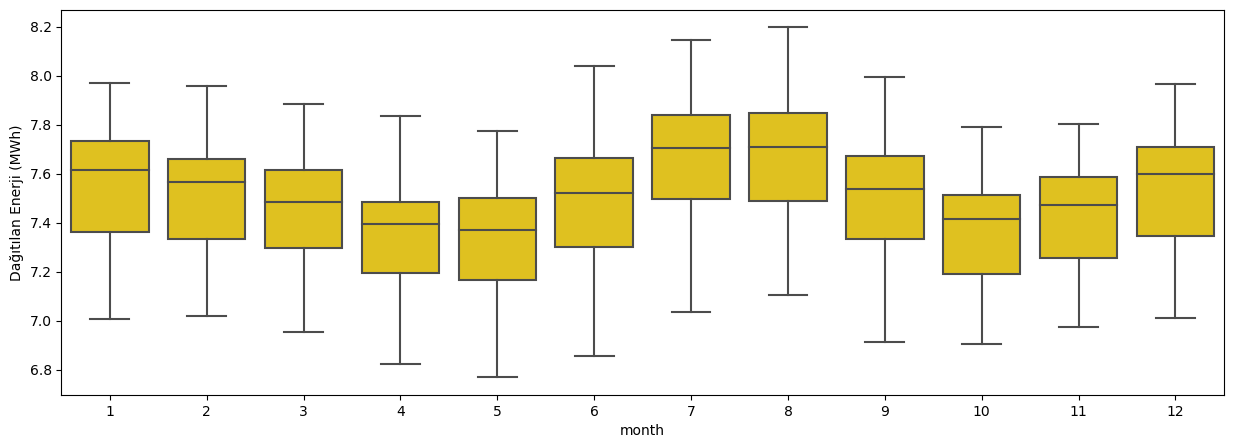

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='Dağıtılan Enerji (MWh)', color='gold')

<AxesSubplot:xlabel='hour', ylabel='Dağıtılan Enerji (MWh)'>

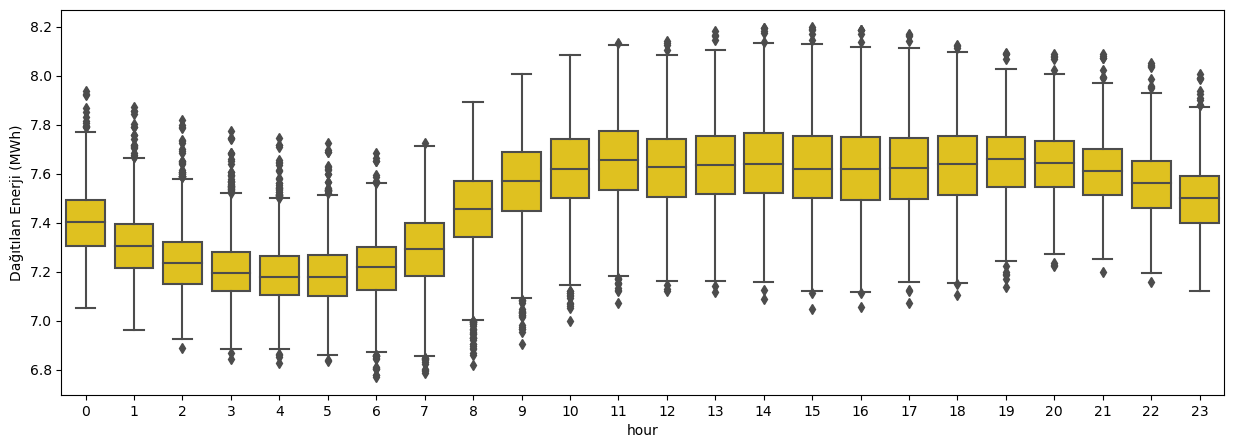

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour', y='Dağıtılan Enerji (MWh)', color='gold')

In [20]:
from prophet import Prophet

In [21]:
hol = df[['Tarih', 'is_ramadan']]
hol = hol[hol['is_ramadan'] == 1]
hol.rename(columns={'Tarih':'ds',
            'is_ramadan':'holiday'},
           inplace=True)
hol['holiday'] = hol['holiday'].astype(str)

In [22]:
model = Prophet(holidays=hol)

In [23]:
model.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=10)
model.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')
model.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')
model.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')
model.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')
model.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
model.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
model.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')
model.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')
model.add_seasonality(name='monthly',
                     period=30.5,
                     fourier_order=10)
model.add_seasonality(name='quarterly',
                     period=91.3125,
                     fourier_order=10)

In [24]:
train_full = df.loc[df['Tarih'] < '2022-08-01', :]
test = df.loc[df['Tarih'] >= '2022-08-01', :]

In [25]:
print(train_full.shape, test.shape)

(40122, 18) (744, 18)


In [26]:
train_prop = train_full[[col for col in train_full.columns if col not in ['is_ramadan']]]
test_prop = test[[col for col in test.columns if col not in ['is_ramadan']]]

In [27]:
train_prop.rename(columns={
    'Tarih':'ds',
    'Dağıtılan Enerji (MWh)':'y'
},
                 inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
model.fit(train_prop)

09:56:22 - cmdstanpy - INFO - Chain [1] start processing
09:58:09 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
train_preds = model.predict(train_prop.drop('y', axis=1))

In [30]:
test_prop.rename(columns={
    'Tarih':'ds',
    'Dağıtılan Enerji (MWh)':'y'
},
                 inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
test_preds = model.predict(test_prop.drop('y', axis=1))

In [32]:
train_prop.shape[0] + test_prop.shape[0] == len(train_preds) + len(test_preds)

True

In [33]:
prop_both = pd.concat([train_preds, test_preds], ignore_index=True)

In [34]:
df_ = pd.merge(df, prop_both, left_on=['Tarih'], right_on=['ds'], how='inner')

In [35]:
def random_noise(dataframe):
    return np.random.normal(scale=1.5, size=(len(dataframe),))


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['MWh_lag_' + str(lag)] = dataframe['Dağıtılan Enerji (MWh)'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [36]:
# pd.DataFrame({'MWh': df_['Dağıtılan Enerji (MWh)'].values[0:10],
#              'lag1': df_['Dağıtılan Enerji (MWh)'].shift(1).values[0:10],
#              'lag2': df_['Dağıtılan Enerji (MWh)'].shift(2).values[0:10]})

In [37]:
df_ = lag_features(df_, [672, 696, 720, 744, 768, 792, 816, 840, 1008, 1344, 8640])

In [38]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['MWh_roll_mean_' + str(window)] = dataframe['Dağıtılan Enerji (MWh)']. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [39]:
# pd.DataFrame({'MWh': df_['Dağıtılan Enerji (MWh)'].values[0:10],
#              'roll2': df_['Dağıtılan Enerji (MWh)'].shift(1).rolling(window=2).mean().values[0:10],
#              'roll3': df_['Dağıtılan Enerji (MWh)'].shift(1).rolling(window=3).mean().values[0:10],
#              'roll5': df_['Dağıtılan Enerji (MWh)'].shift(1).rolling(window=5).mean().values[0:10]})

In [40]:
df_ = roll_mean_features(df_, [672, 696, 720, 744, 768, 792, 816, 840])

In [41]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['MWh_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['Dağıtılan Enerji (MWh)'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [42]:
# pd.DataFrame({'MWh': df_['Dağıtılan Enerji (MWh)'].values[0:10],
#              'roll2': df_['Dağıtılan Enerji (MWh)'].shift(1).rolling(window=2).mean().values[0:10],
#              'ewm99': df_['Dağıtılan Enerji (MWh)'].shift(1).ewm(alpha=.99).mean().values[0:10],
#              'ewm95': df_['Dağıtılan Enerji (MWh)'].shift(1).ewm(alpha=.95).mean().values[0:10],
#              'ewm70': df_['Dağıtılan Enerji (MWh)'].shift(1).ewm(alpha=.7).mean().values[0:10],
#              'ewm20': df_['Dağıtılan Enerji (MWh)'].shift(1).ewm(alpha=.2).mean().values[0:10]})

In [43]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.6]
lags = [672, 696, 720, 744, 768, 792, 816, 840, 1008, 1344, 8640]

In [44]:
df_ = ewm_features(df_, alphas, lags)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


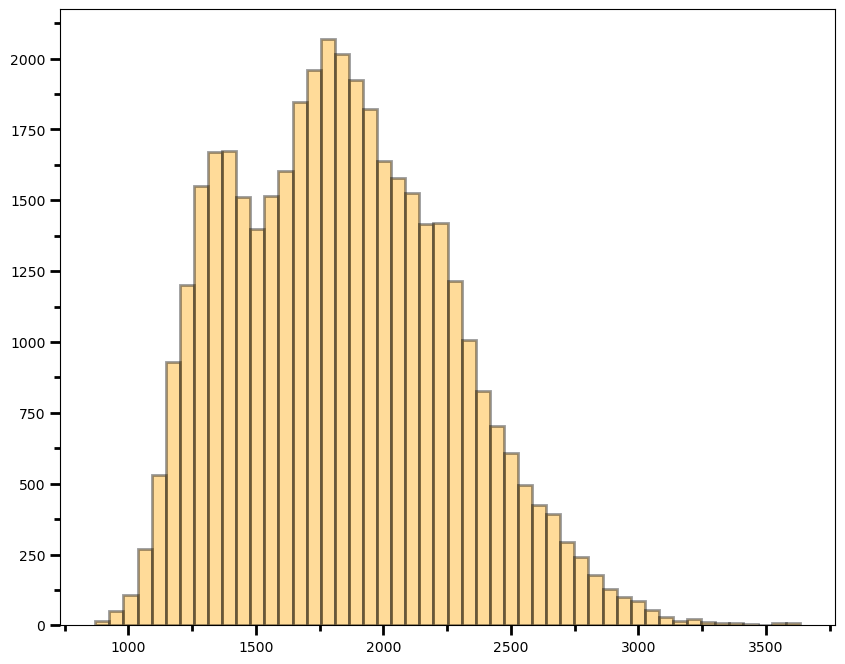

In [45]:
plt.figure(figsize=(10, 8))
ax = sns.distplot(x=np.exp(df_['Dağıtılan Enerji (MWh)']), kde=False, color="orange",
                  hist_kws=dict(edgecolor="black", linewidth=2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which="both", width=2)
ax.tick_params(which="major", length=7)
ax.tick_params(which="minor", length=4)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


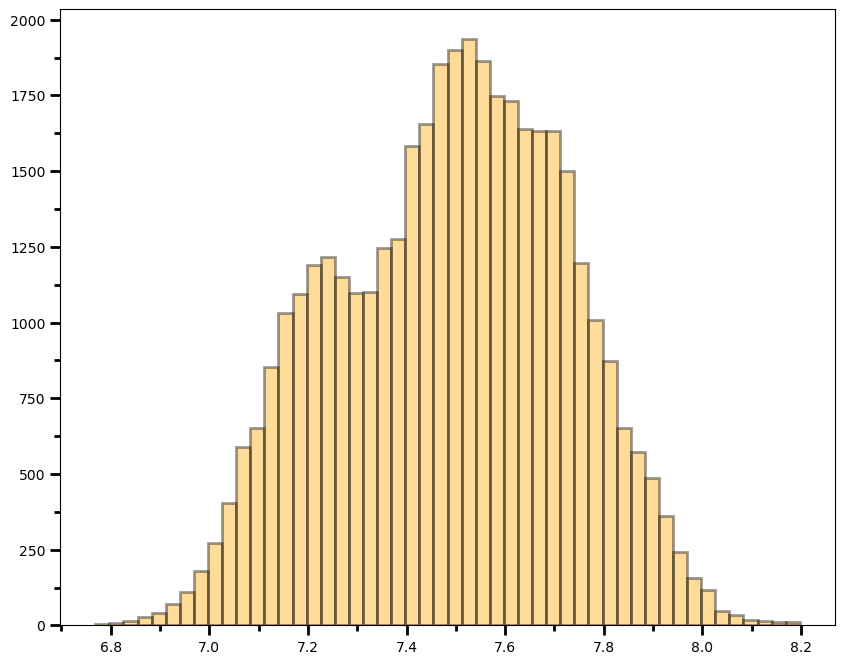

In [46]:
plt.figure(figsize=(10, 8))
ax = sns.distplot(x=df_['Dağıtılan Enerji (MWh)'], kde=False, color="orange",
                  hist_kws=dict(edgecolor="black", linewidth=2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which="both", width=2)
ax.tick_params(which="major", length=7)
ax.tick_params(which="minor", length=4)
plt.show()

In [47]:
cols = [col for col in df_.columns if col not in ['Tarih', 'Dağıtılan Enerji (MWh)', 'ds']]

In [48]:
train = df_.loc[df_['Tarih'] < '2022-07-01', :]
val = df_.loc[(df_['Tarih'] >= '2022-07-01') & (df_['Tarih'] < '2022-08-01'), :]
print(train.shape, val.shape)

(39378, 150) (744, 150)


In [49]:
y_train = train['Dağıtılan Enerji (MWh)']
X_train = train[cols]

y_val = val['Dağıtılan Enerji (MWh)']
X_val = val[cols]

In [50]:
import lightgbm as lgb

In [51]:
lgb_parameters = {'metric': {'mape'},
                  'num_leaves': 10,
                  'learning_rate': 0.02,
                  'feature_fraction': 0.8,
                  'max_depth': 5,
                  'verbose': 0,
                  'num_boost_round': 1000,
                  'early_stopping_rounds': 500,
                  'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=cols)

In [52]:
lgb_model = lgb.train(lgb_parameters, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_parameters['num_boost_round'],
                  early_stopping_rounds=lgb_parameters['early_stopping_rounds'],
                  verbose_eval=200)

print(lgb_model.best_score['valid_1']['mape'])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035501 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 500 rounds
[200]	training's mape: 0.00705934	valid_1's mape: 0.00938329
[400]	training's mape: 0.00630148	valid_1's mape: 0.00936546
[600]	training's mape: 0.00575174	valid_1's mape: 0.00944483
[800]	training's mape: 0.00538857	valid_1's mape: 0.00940947
Early stopping, best iteration is:
[317]	training's mape: 0.00655656	valid_1's mape: 0.00933239
0.009332391341740366


In [53]:
lgb_grid_parameters = {
    'metric': {'mape'},
    'learning_rate': [0.01, 0.02, 0.1, 0.2],
    'max_depth': [n for n in range(4, 11, 2)],
    'num_leaves': [n for n in range(5, 23, 2)],
    'feature_fraction': [0.5, 0.7, 0.8, 1],
    'verbose': -1,
    'num_boost_round': [1000, 2000, 3000],
    'early_stopping_rounds': 500,
    'nthread': -1
}

In [54]:
def lgb_param_search(lgb_param_dict):
    min_error = float("inf")
    best_params = dict()
    best_iter = float("inf")
    for i in range(len(lgb_param_dict['learning_rate'])):
        lgb_try_params = dict()
        lgb_try_params['metric'] = {'mape'}
        lgb_try_params['verbose'] = -1
        lgb_try_params['nthread'] = -1
        lgb_try_params['learning_rate'] = lgb_param_dict['learning_rate'][i]
        for j in range(len(lgb_param_dict['max_depth'])):
            lgb_try_params['max_depth'] = lgb_param_dict['max_depth'][j]
            for k in range(len(lgb_param_dict['num_leaves'])):
                lgb_try_params['num_leaves'] = lgb_param_dict['num_leaves'][k]
                for s in range(len(lgb_param_dict['feature_fraction'])):
                    lgb_try_params['feature_fraction'] = lgb_param_dict['feature_fraction'][s]
                    for e in range(len(lgb_param_dict['num_boost_round'])):
                        lgb_try_params['num_boost_round'] = lgb_param_dict['num_boost_round'][e]
                    print('Fitting the model: ')
                    model = lgb.train(lgb_try_params, lgbtrain,
                                      valid_sets=[lgbtrain, lgbval],
                                      num_boost_round=lgb_try_params['num_boost_round'],
                                      early_stopping_rounds=lgb_grid_parameters['early_stopping_rounds'],
                                      verbose_eval=2000)
                    print('Model\'s score: ' + str(model.best_score['valid_1']['mape']))
                    if min_error > model.best_score['valid_1']['mape']:
                        min_error = model.best_score['valid_1']['mape']
                        best_params = model.params
                        best_iter = model.best_iteration
                    else:
                        continue
    return min_error, best_params, best_iter

In [55]:
min_error, best_params, best_iter = lgb_param_search(lgb_grid_parameters)

Fitting the model: 
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1000]	training's mape: 0.00679335	valid_1's mape: 0.0091417
Model's score: 0.009141701358382591
Fitting the model: 
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[959]	training's mape: 0.00683174	valid_1's mape: 0.00930141
Model's score: 0.009301410392513913
Fitting the model: 
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[962]	training's mape: 0.00681123	valid_1's mape: 0.00921805
Model's score: 0.009218047495107993
Fitting the model: 
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1000]	training's mape: 0.00677767	valid_1's mape: 0.00919235
Model's score: 0.009192347737086307
Fitting the model: 
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[854]	training's mape: 0.0

In [56]:
best_params

{'metric': {'mape'},
 'verbose': -1,
 'nthread': -1,
 'learning_rate': 0.2,
 'max_depth': 6,
 'num_leaves': 17,
 'feature_fraction': 0.5,
 'num_iterations': 3000,
 'early_stopping_round': 500}

In [57]:
train_full = df_.loc[df_['Tarih'] < '2022-08-01', :]

In [58]:
y_train_full = train_full['Dağıtılan Enerji (MWh)']
X_train_full = train_full[cols]

In [59]:
lgbtrain_all = lgb.Dataset(data=X_train_full, label=y_train_full, feature_name=cols)

In [60]:
best_param_grid = {
    'metric': {'mape'},
 'verbose': -1,
 'nthread': -1,
 'learning_rate': 0.2,
 'max_depth': 6,
 'num_leaves': 17,
 'feature_fraction': 0.5,
 'num_iterations': 3000
}

In [61]:
final_model = lgb.train(best_param_grid, lgbtrain_all)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [62]:
test = df_.loc[df_['Dağıtılan Enerji (MWh)'].isna()]

In [63]:
test.shape

(744, 150)

In [64]:
X_test = test[cols]

In [65]:
preds = final_model.predict(X_test)

In [66]:
preds[0:5]

array([7.69075253, 7.60436934, 7.53349981, 7.50808917, 7.47905338])

In [67]:
sub_samp = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', parse_dates=['Tarih'])
sub_samp.set_index('Tarih', inplace=True)

In [68]:
output_df = pd.DataFrame({'Tarih':sub_samp.index,
             'Dağıtılan Enerji (MWh)':np.exp(preds)})

In [69]:
output_df.to_csv('submission_output.csv', index=False)

In [70]:
print(output_df.head())
print(output_df.tail())

                Tarih  Dağıtılan Enerji (MWh)
0 2022-08-01 00:00:00                2188.020
1 2022-08-01 01:00:00                2006.946
2 2022-08-01 02:00:00                1869.637
3 2022-08-01 03:00:00                1822.727
4 2022-08-01 04:00:00                1770.564
                  Tarih  Dağıtılan Enerji (MWh)
739 2022-08-31 19:00:00                2323.198
740 2022-08-31 20:00:00                2325.962
741 2022-08-31 21:00:00                2280.515
742 2022-08-31 22:00:00                2194.868
743 2022-08-31 23:00:00                2072.534
